# Contiguous Rain Area (CRA)

The Contiguous Rain Area (CRA) method is an object-oriented verification technique developed to address the limitations of traditional point-wise metrics in evaluating precipitation forecasts. Rather than comparing individual grid points, CRA focuses on coherent rain structures — contiguous areas of rainfall above a specified threshold — and assesses how well these structures are forecasted in terms of their location, intensity, and spatial pattern. This approach is particularly valuable for diagnosing systematic errors in weather systems, such as displacement or misrepresentation of rain features, which are often obscured by conventional metrics like RMSE or bias.

The method begins by applying a fixed rainfall threshold to both the forecast and observed fields to identify contiguous rain areas (CRAs). These areas are treated as spatial objects, and the forecast CRA is shifted within a defined search window to find the best alignment with the observed CRA. The alignment is determined by minimizing the mean squared error (MSE) between the forecast and observation. Once the best alignment is found, the CRA method decomposes the total error into three components: location error (the spatial shift required), volume error (difference in total rainfall volume), and pattern error (the residual error after alignment and volume adjustment).

CRA offers several strengths. It provides a more diagnostic and interpretable assessment of forecast performance, especially for high-impact events like convective systems or tropical cyclones. It is resolution-aware, allowing fair comparisons between high-resolution and coarser models, and it is particularly suited for regional domains where spatial accuracy is critical. CRA can be applied across multiple lead times to assess forecast evolution and timing errors, and it can be extended to multivariate fields or composite variables to evaluate joint behavior. Aggregating CRA metrics over time or space also helps reduce sampling variability and reveal systematic biases.

However, CRA has limitations. It requires both the forecast and observation to contain at least ten grid points above the threshold; otherwise, the case is excluded, potentially omitting important underprediction scenarios. Matching CRAs can be ambiguous in complex or fragmented rain fields, and the method depends on gridded observational datasets (reanalysis products), which may introduce uncertainty.

To learn more about CRA, please see the following articles:

- Ebert, E., & McBride, J. (2000), Verification of precipitation in weather systems: Determination of systematic errors. Journal of Hydrology, 239(1–4), 179–202. [https://doi.org/10.1016/S0022-1694(00)00343-7](https://doi.org/10.1016/S0022-1694(00)00343-7)
  
- Ebert, E. E., and W. A. Gallus , 2009: Toward Better Understanding of the Contiguous Rain Area (CRA) Method for Spatial Forecast Verification. Wea. Forecasting, 24, 1401–1415, [https://doi.org/10.1175/2009WAF2222252.1](https://doi.org/10.1175/2009WAF2222252.1)


In [2]:
from scores.spatial import cra
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import xarray as xr

Let's generate some random observation and forecast fields of 24-hour rainfall. We'll apply different rotation angles to each field, and ensure the forecast contains generally lower values than the observations. 

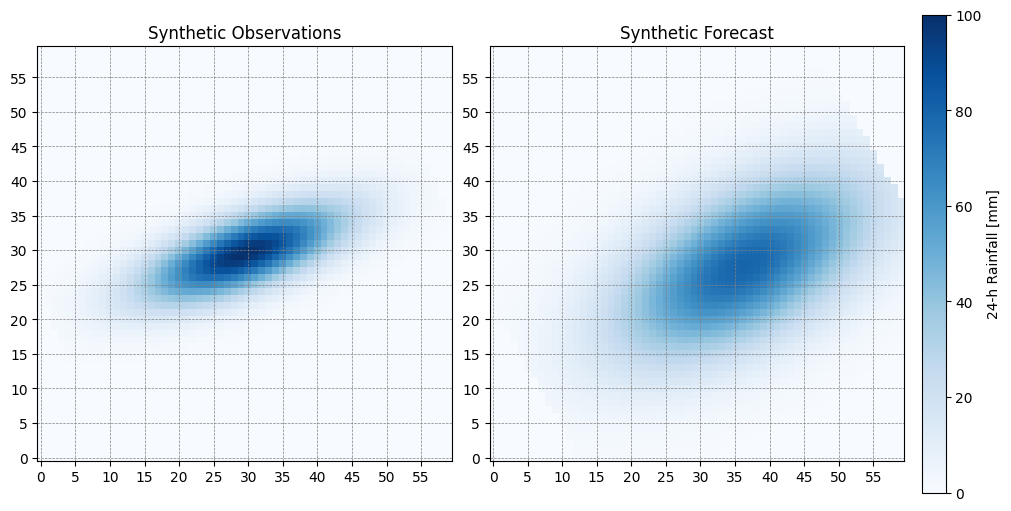

In [3]:
# Grid size
nx, ny = 60, 60

x_vals = np.linspace(-3, 3, nx)
y_vals = np.linspace(-3, 3, ny)
x, y = np.meshgrid(x_vals, y_vals)

# Create an elongated tilted Gaussian blob for observations
obs = np.exp(-((x / 1.5)**2 + (y / 0.5)**2)) * 100 # peak around 100mm
obs = rotate(obs, angle=-20, reshape=False)

# Create forecast blob: shifted and with reduced intensity
fcst = np.exp(-(((x-0.5)*0.5)**2 + ((y+0.5))**2)) * 80  # peak around 80 mm
fcst = rotate(fcst, angle=-30, reshape=False)


# Plot both fields side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
cmap = 'Blues'
vmin, vmax = 0, 100

im1 = axes[0].imshow(obs, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
axes[0].set_title('Synthetic Observations')
axes[0].set_xticks(np.arange(0, nx, 5))
axes[0].set_yticks(np.arange(0, ny, 5))
axes[0].grid(True, color='gray', linestyle='--', linewidth=0.5)

im2 = axes[1].imshow(fcst, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
axes[1].set_title('Synthetic Forecast')

axes[1].set_xticks(np.arange(0, nx, 5))
axes[1].set_yticks(np.arange(0, ny, 5))
axes[1].grid(True, color='gray', linestyle='--', linewidth=0.5)


fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.05, pad=0.02, label='24-h Rainfall [mm]')


Next, we'll apply a mask to filter out values below 30 mm. Note that this step isn't required for using the CRA function; it's simply to help visualize the rainfall blobs of interest.

In [4]:
THRESHOLD = 30

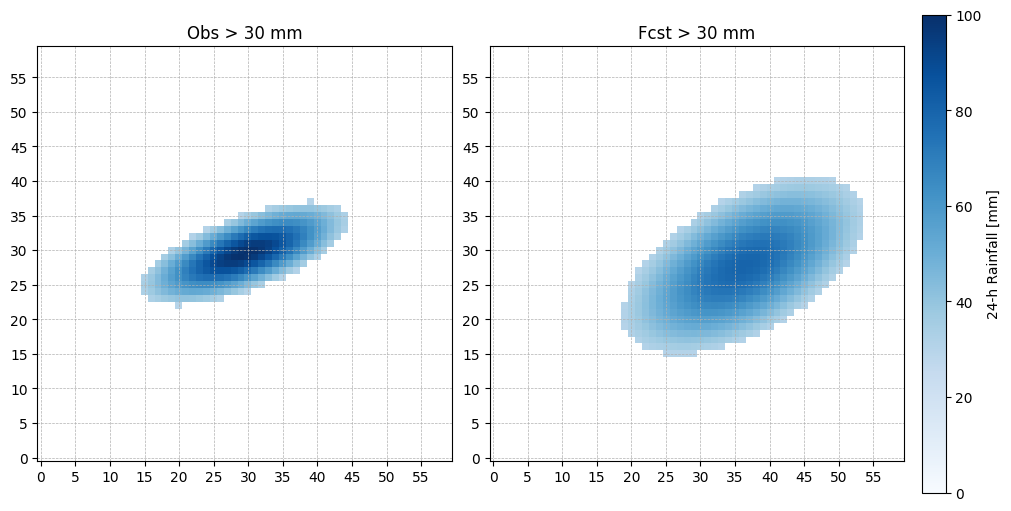

In [5]:
obs_masked = np.ma.masked_less(obs, THRESHOLD)
fcst_masked = np.ma.masked_less(fcst, THRESHOLD)


# Plot both masked fields side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
cmap = 'Blues'
vmin, vmax = 0, 100

im1 = axes[0].imshow(obs_masked, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
axes[0].set_title('Obs > 30 mm')
axes[0].set_xticks(np.arange(0, nx, 5))
axes[0].set_yticks(np.arange(0, ny, 5))
axes[0].grid(True, linestyle='--', linewidth=0.5)

im2 = axes[1].imshow(fcst_masked, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
axes[1].set_title('Fcst > 30 mm')
axes[1].set_xticks(np.arange(0, nx, 5))
axes[1].set_yticks(np.arange(0, ny, 5))
axes[1].grid(True, linestyle='--', linewidth=0.5)

# Shared colorbar
fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.05, pad=0.02, label='24-h Rainfall [mm]')


In [6]:
# Convert to xarray.DataArray with latitude and longitude coordinates
lat = y_vals
lon = x_vals

obs_da = xr.DataArray(obs, coords=[("y", y_vals), ("x", x_vals)], name="observed_rainfall")
fcst_da = xr.DataArray(fcst, coords=[("y", y_vals), ("x", x_vals)], name="forecast_rainfall")

In [7]:
cra_dict = cra(fcst_da, obs_da, THRESHOLD)

[-6, 2]


In [8]:
# Print MSE decomposition
print(f"MSE TOTAL: {int(cra_dict['mse_total'])} mm^2")
print(f"MSE Displacement: {int(cra_dict['mse_displacement'])} mm^2 => {int(cra_dict['mse_displacement']/cra_dict['mse_total']*100)}%")
print(f"MSE Volume: {int(cra_dict['mse_volume'])} mm^2 => {int(cra_dict['mse_volume']/cra_dict['mse_total']*100)}%")
print(f"MSE Pattern: {int(cra_dict['mse_pattern'])} mm^2 => {int(cra_dict['mse_pattern']/cra_dict['mse_total']*100)}%")

MSE TOTAL: 678 mm^2
MSE Displacement: 503 mm^2 => 74%
MSE Volume: 60 mm^2 => 8%
MSE Pattern: 114 mm^2 => 16%


In [9]:
# You can check all metrics available in CRA
cra_dict.keys()

dict_keys(['mse_total', 'mse_displacement', 'mse_volume', 'mse_pattern', 'fcst_blob', 'obs_blob', 'shifted_fcst', 'optimal_shift', 'num_gridpoints_above_threshold_fcst', 'num_gridpoints_above_threshold_obs', 'avg_fcst', 'avg_obs', 'max_fcst', 'max_obs', 'corr_coeff_original', 'corr_coeff_shifted', 'rmse_original', 'rmse_shifted', 'TEST'])

We will plot the "optimal" shifted forecast:

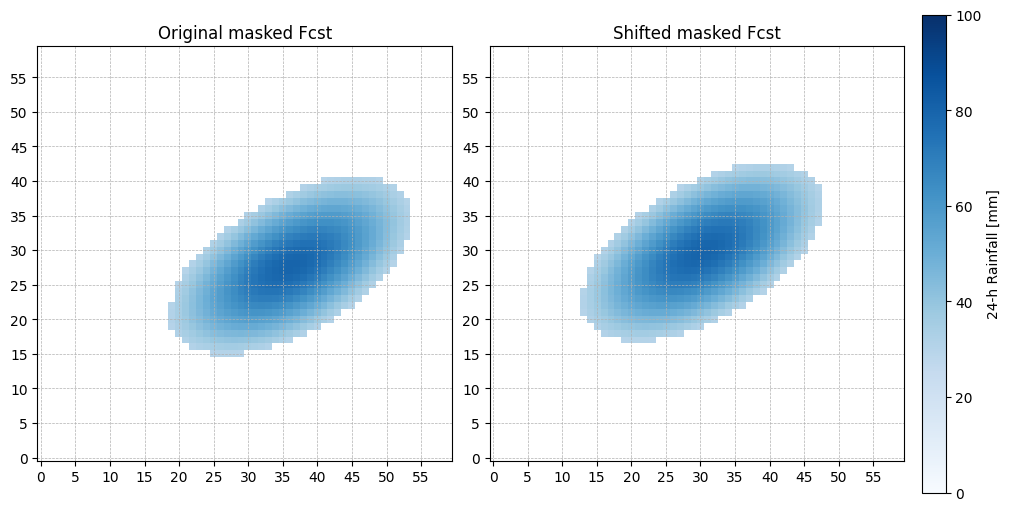

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
cmap = 'Blues'
vmin, vmax = 0, 100

im1 = axes[0].imshow(fcst_masked, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
axes[0].set_title('Original masked Fcst')
axes[0].set_xticks(np.arange(0, nx, 5))
axes[0].set_yticks(np.arange(0, ny, 5))
axes[0].grid(True, linestyle='--', linewidth=0.5)

im2 = axes[1].imshow(cra_dict['shifted_fcst'], origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
axes[1].set_title('Shifted masked Fcst')
axes[1].set_xticks(np.arange(0, nx, 5))
axes[1].set_yticks(np.arange(0, ny, 5))
axes[1].grid(True, linestyle='--', linewidth=0.5)

# Shared colorbar
fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.05, pad=0.02, label='24-h Rainfall [mm]')

In [11]:
# Optimal shift
cra_dict['optimal_shift'] 
#[-6,2] => The forecast field has been shifted 6 grid points to the west and 2 grid points to the north


[-6, 2]

In [12]:
# Other metrics
print(f"Number of grid points above threshold in obs: {cra_dict['num_gridpoints_above_threshold_obs']}")
print(f"Number of grid points above threshold in fcst: {cra_dict['num_gridpoints_above_threshold_fcst']}")

Number of grid points above threshold in obs: 268
Number of grid points above threshold in fcst: 596


In [13]:
print(f"Average obs: {int(cra_dict['avg_obs'])} mm")
print(f"Average fcst: {int(cra_dict['avg_fcst'])} mm")

Average obs: 58 mm
Average fcst: 50 mm


In [14]:
print(f"Max obs: {int(cra_dict['max_obs'])} mm")
print(f"Max fcst: {int(cra_dict['max_fcst'])} mm")

Max obs: 99 mm
Max fcst: 79 mm


In [15]:
print(f"Original Correlation Coefficient: {cra_dict['corr_coeff_original']}")
print(f"Shifted Correlation Coefficient: {cra_dict['corr_coeff_shifted']}")

Original Correlation Coefficient: -0.0711568998687387
Shifted Correlation Coefficient: 0.8282201710510215


In [16]:
print(f"Original RMSE: {int(cra_dict['rmse_original'])} mm")
print(f"Shited RMSEt: {int(cra_dict['rmse_shifted'])} mm")

Original RMSE: 26 mm
Shited RMSEt: 13 mm


## Things to try next

Experiment with modifying the synthetic observations and/or forecast fields to see how the CRA-associated metrics respond. You can also adjust the `THRESHOLD` parameter to explore its impact on the results. 